# Cheatsheet for common operations<a id="top"></a>

_Developed by Davíd Brakenhoff (Artesia) on July 19, 2019_
<hr>

This notebook contains code snippets for performing common operations on water balances.

## Contents

- [Simplest way to simulate a waterbalance](#1)
- [Simplest way to simulate water quality](#1.1)
- [Comparing Python waterbalance to Excel waterbalance](#2)
- [Export simulation results to csv](#3)
- [Extend simulation period of existing waterbalance](#4)
- [Change an input parameter value after first simulation](#5)
- [Add a bucket to an existing EAG](#6)

Import relevant modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import waterbalans as wb

## [Simplest way to run a waterbalance](#top)<a id="1"></a>

The simplest way to run a waterbalance is to use the `wb.run_eag_by_name()` function. This function picks up all the relevant CSVs from the provided `csvdir` and does all the work for you.

In [2]:
e = wb.run_eag_by_name("2250-EAG-2", csvdir="../../data/input_csv")

2019-07-23 14:14:35,451 | create_eag - INFO : Creating EAG object for '2250-EAG-2'
2019-07-23 14:14:35,478 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2019-07-23 14:14:37,349 | get_series - INFO : Adding FEWS timeseries 'Gemaal1Debiet Pomp 1': polder|Pompvolumes|60151_pomp_1|Vol.berekend.dag.
2019-07-23 14:14:38,728 | get_series - INFO : Adding FEWS timeseries 'Neerslag': meteo_meetstation_KNMI|ImportCAW|66005cal|P.meting.dagcal.
2019-07-23 14:14:40,104 | get_series - INFO : Adding FEWS timeseries 'Peil': polder|Statistiek|60151_onderbemaling|H.meting.gem.
2019-07-23 14:14:40,969 | get_series - INFO : Adding FEWS timeseries 'Verdamping': meteo_meetstation_KNMI|ImportCAW|66002_VerdampingCAL|E.metingcal.
2019-07-23 14:14:41,370 | add_timeseries - INFO : Adding timeseries 'Gemaal1' to EAG manually
2019-07-23 14:14:41,372 | add_timeseries - INFO : Filled 2187 NaN-values with '0.0' in series Gemaal1.
2019-07-23 14:14:41,380 | add_timeseries

## [Simplest way to simulate water quality](#top)<a id="1.1"></a>

Simulating water quality requires a bit more work, the file containing the water quality parameters has to be loaded and edited somewhat to work nice with the Python module.

In [3]:
# bestand met concentraties van stof per flux
fosfor = pd.read_csv(r"../../data/input_csv/stoffen_fosfor_85_2250-EAG-2.csv", delimiter=";", decimal=",")
fosfor.columns = [icol.capitalize() for icol in fosfor.columns]
fosfor.replace("Riolering", "q_cso", inplace=True)
fosfor["Waarde"] = pd.to_numeric(fosfor["Waarde"])
fosfor["Stofincrement"] = pd.to_numeric(fosfor["Stofincrement"])

Simulate the water quality twice (once for the lower limit, and once for the upper limit).

In [4]:
# Simuleer de waterkwaliteit (ondergrens en bovengrens)
mass_in, mass_out, mass_fosfor = e.simulate_wq(fosfor)
mass_in_max, mass_out_max, mass_fosfor_max = e.simulate_wq(
    fosfor, increment=True)

# Bereken de concentratie
C_fosfor = mass_fosfor / e.water.storage["storage"]
C_fosfor_max = mass_fosfor_max / e.water.storage["storage"]

2019-07-23 14:14:47,512 | simulate_wq - INFO : Simulating water quality: 2250-EAG-2...
2019-07-23 14:14:55,133 | simulate_wq - INFO : Simulation water quality succesfully completed in 7.6s.
2019-07-23 14:14:55,135 | simulate_wq - INFO : Simulating water quality: 2250-EAG-2...
2019-07-23 14:15:03,196 | simulate_wq - INFO : Simulation water quality succesfully completed in 8.1s.


Visualization of the results:

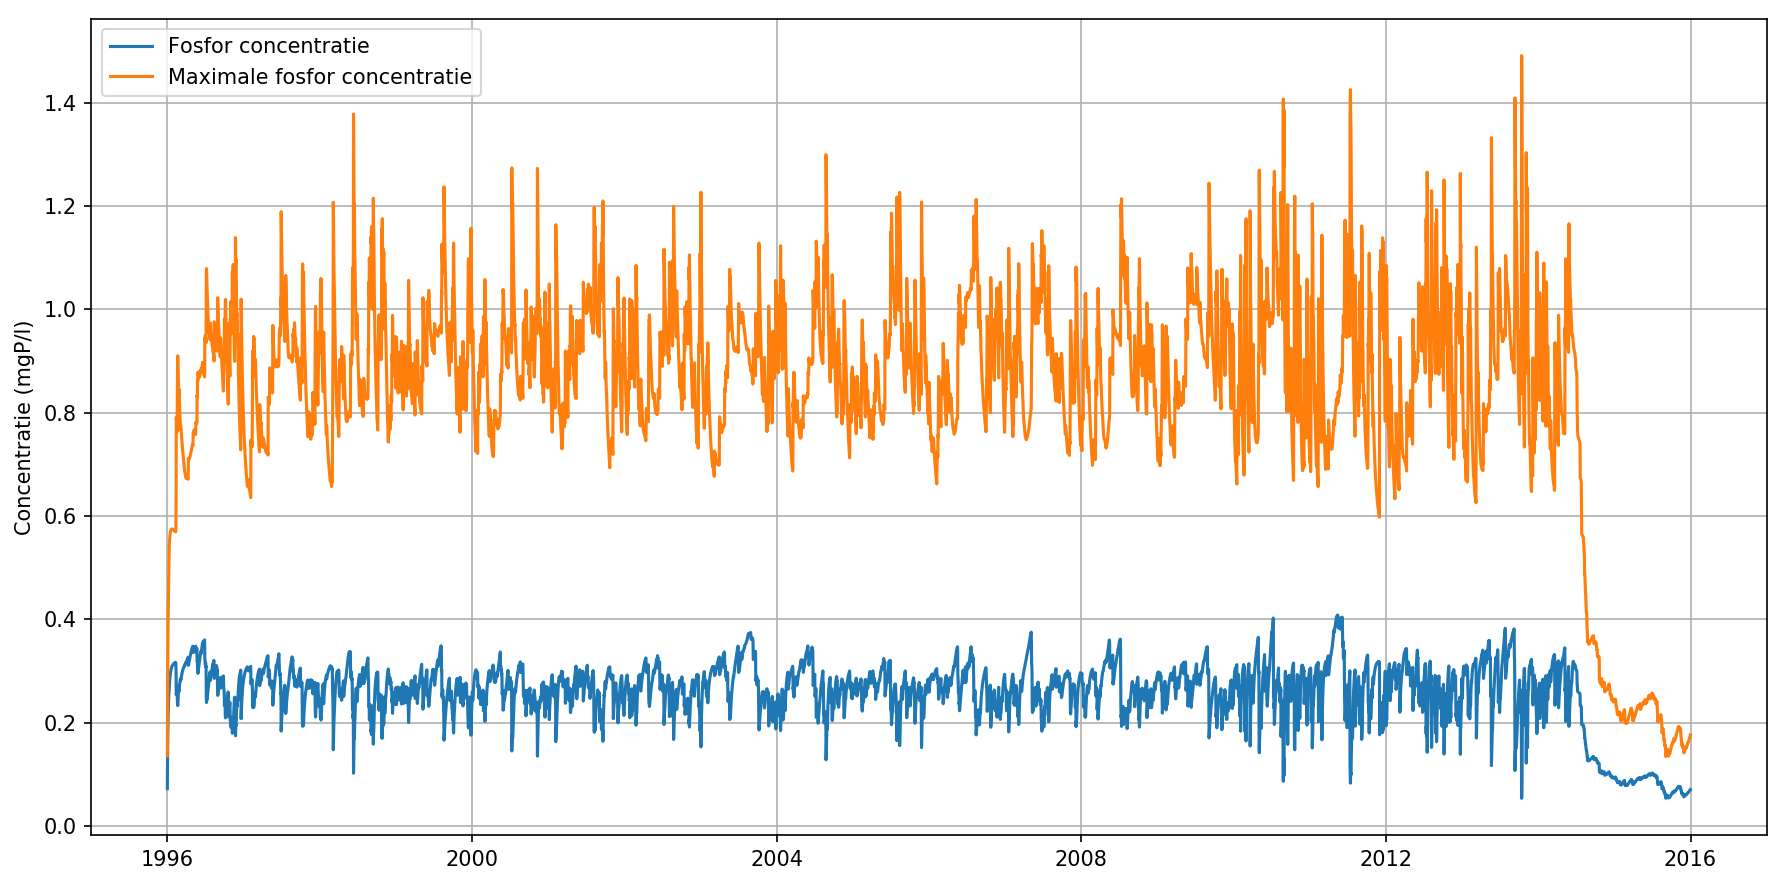

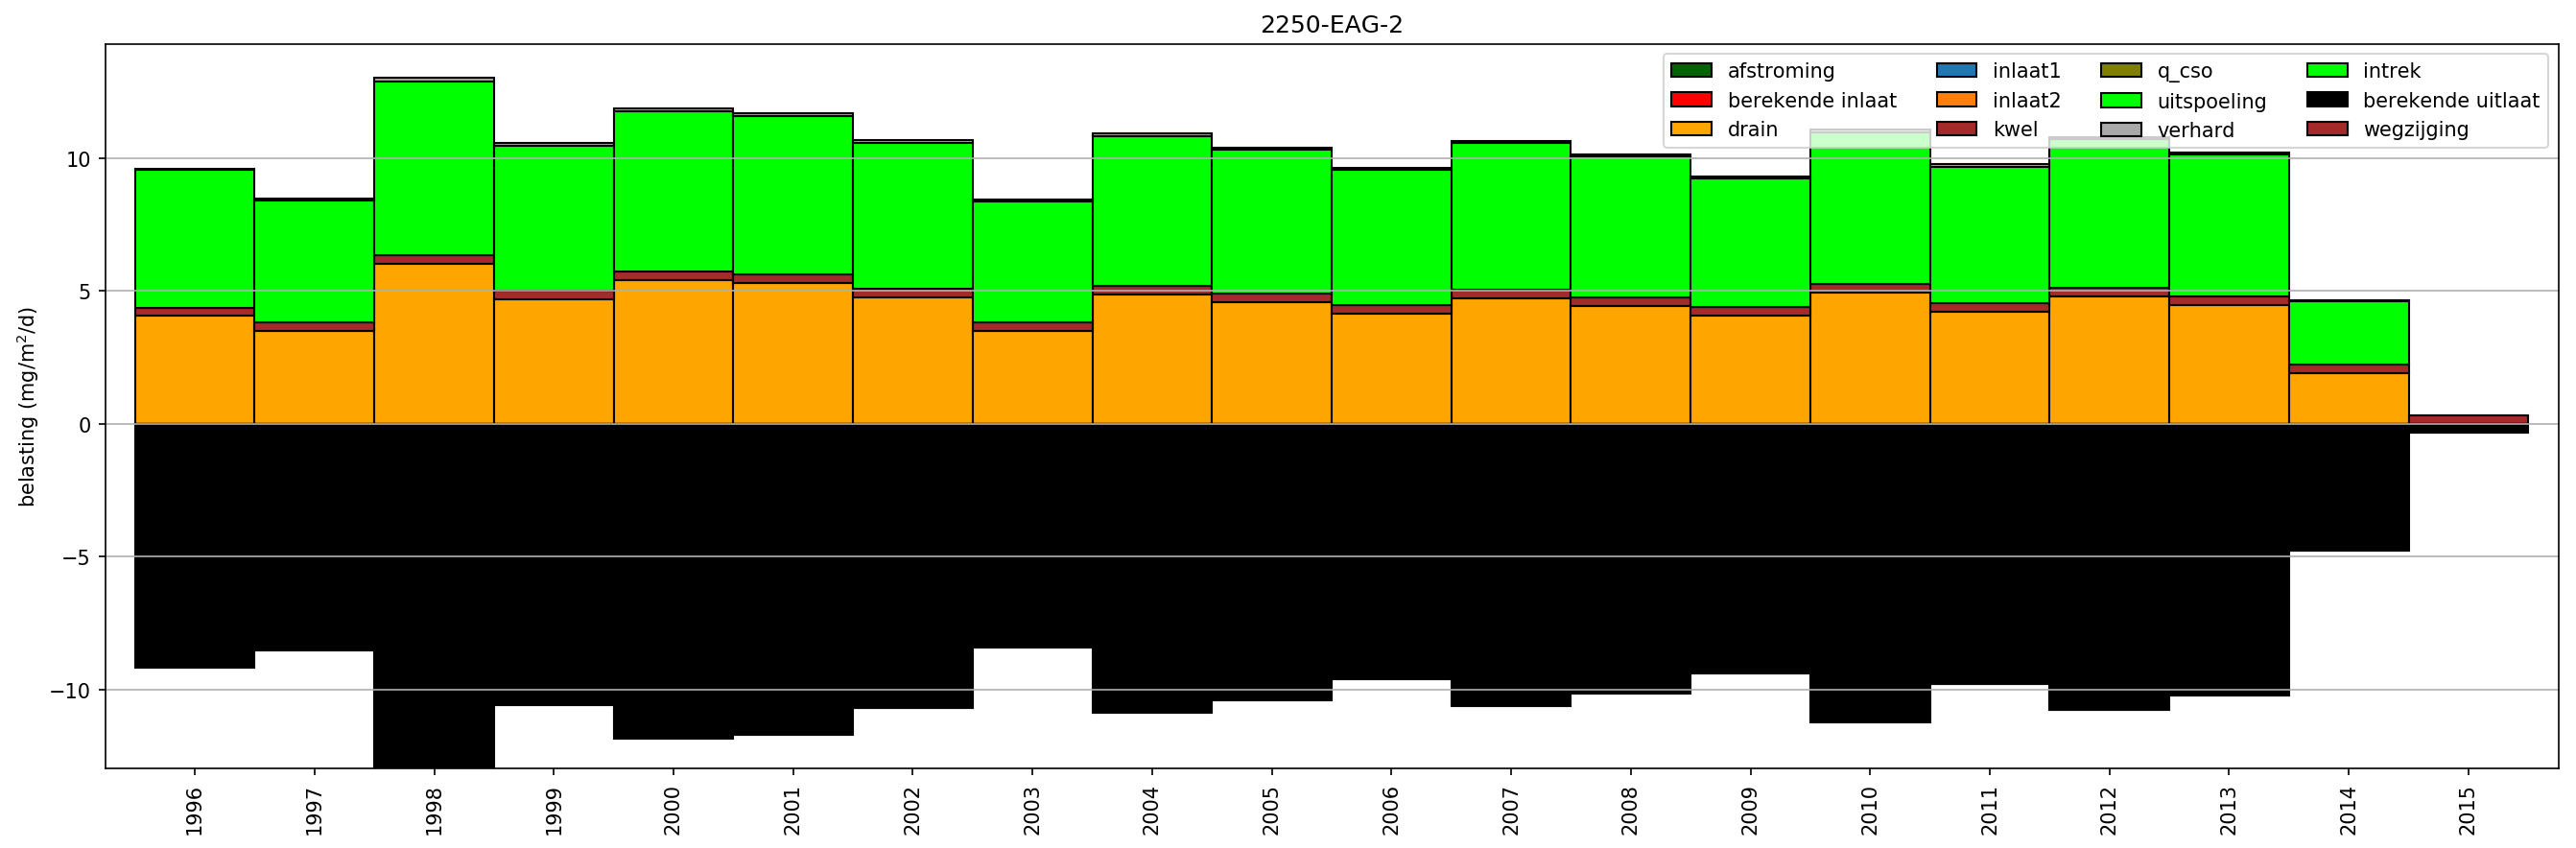

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)
ax.plot(C_fosfor.loc[:"2015"].index, C_fosfor.loc[:"2015"], label="Fosfor concentratie")
ax.plot(C_fosfor_max.loc[:"2015"].index, C_fosfor_max.loc[:"2015"], label="Maximale fosfor concentratie")
ax.legend(loc="best")
ax.set_ylabel("Concentratie (mgP/l)")
ax.grid(b=True)
fig.tight_layout()

ax = e.plot.wq_loading(mass_in, mass_out, tmax="2015")

## [Comparing Python waterbalance to Excel waterbalance](#top)<a id="2"></a>

Comparing to an existing Excel waterbalance requires the data from this Excel balance to be stored somewhere. If this data is available as a pickled DataFrame (as it is in the repository), you can use the function `wb.utils.comare_to_excel_balance()`

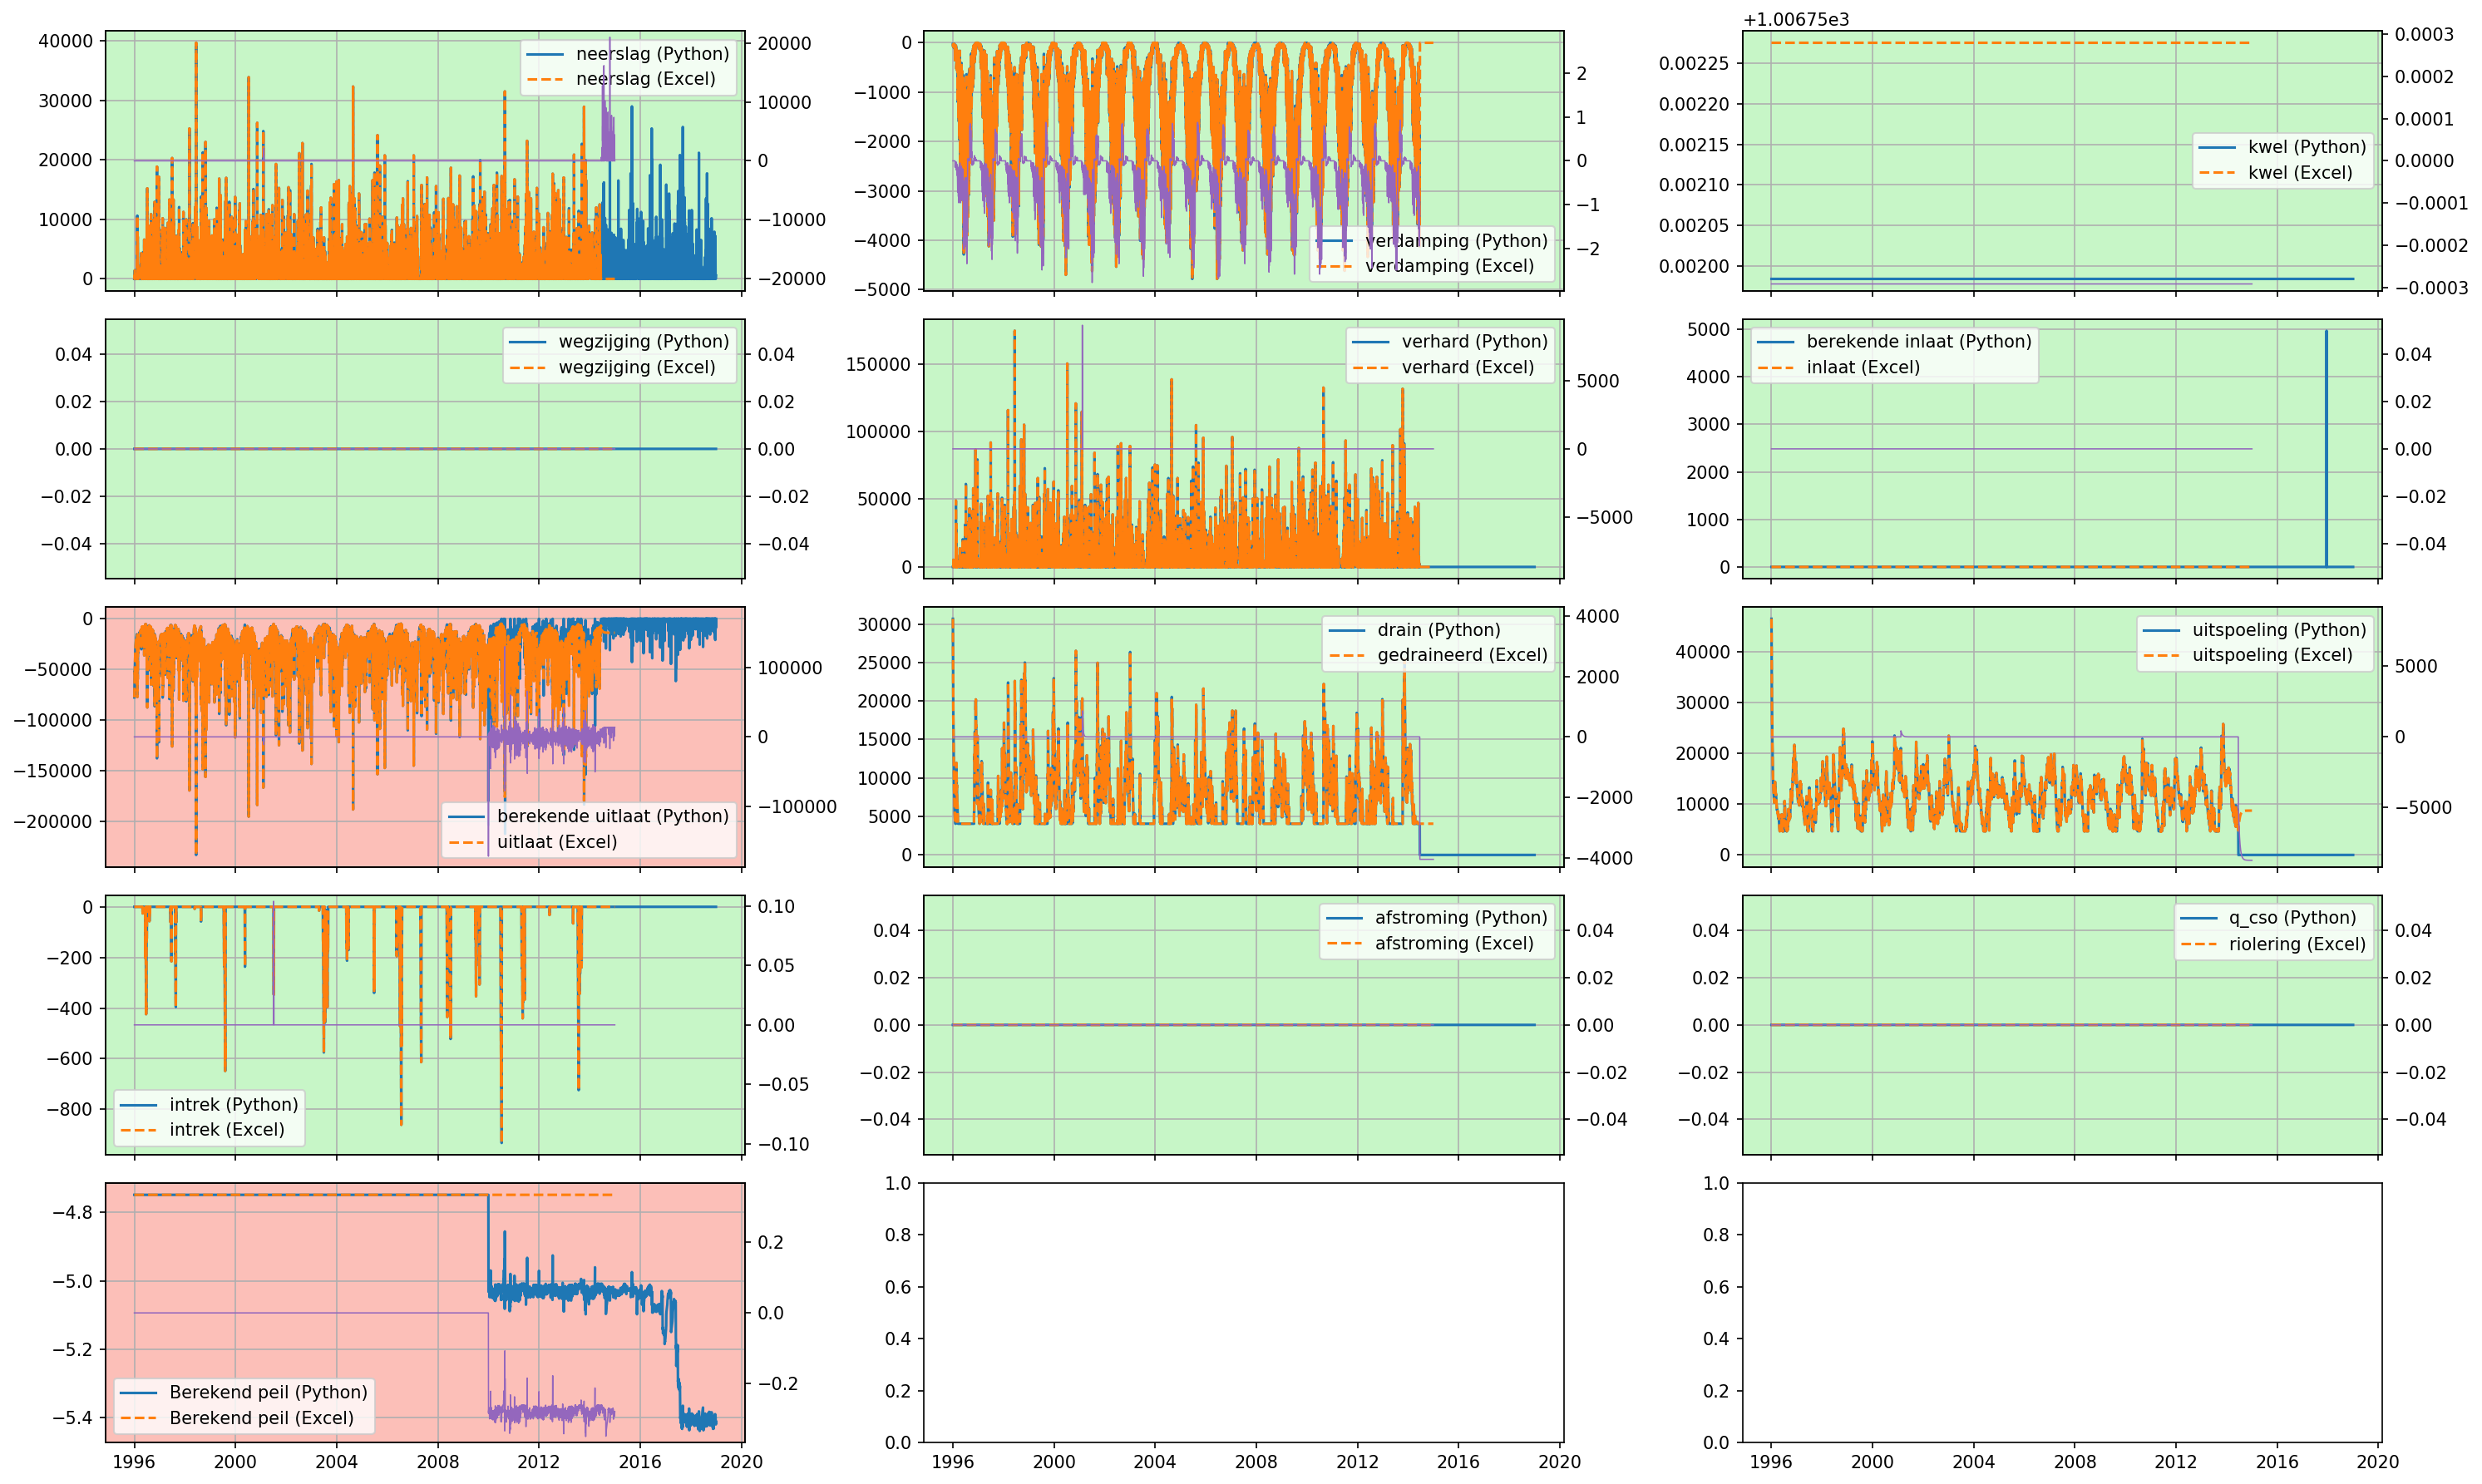

In [6]:
f = wb.utils.compare_to_excel_balance(e, pickle_dir="../../data/excel_pklz")

## [Export simulation results to csv](#top)<a id="3"></a>

The desired output is generally the fluxes or the water quality of the surface water bucket. Each of these parameters is easily obtained as a DataFrame. Exporting to a CSV file is as easy as calling `df.to_csv('<csv_name>.csv')`.

In [7]:
fluxes = e.aggregate_fluxes()

In [8]:
old_water_level = e.water.level.copy()

In [9]:
# fluxes.to_csv("test.csv")

## [Extend simulation period of existing waterbalance](#top)<a id="4"></a>

Extending the simulation period of an existing water balance requires updating the timeseries by adding them again, and then re-running the simulation.

If there are timeseries that are not available in FEWS or KNMI, the timeseries for the new period must be added manually.

In [10]:
df = pd.read_csv("../../data/input_csv/reeks_85_2250-EAG-2.csv", sep=";")
e.add_series_from_database(df, tmin="1995-12-31", tmax="2019")

2019-07-23 14:15:08,935 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2019-07-23 14:15:10,894 | get_series - INFO : Adding FEWS timeseries 'Gemaal1Debiet Pomp 1': polder|Pompvolumes|60151_pomp_1|Vol.berekend.dag.
2019-07-23 14:15:12,335 | get_series - INFO : Adding FEWS timeseries 'Neerslag': meteo_meetstation_KNMI|ImportCAW|66005cal|P.meting.dagcal.
2019-07-23 14:15:13,771 | get_series - INFO : Adding FEWS timeseries 'Peil': polder|Statistiek|60151_onderbemaling|H.meting.gem.
2019-07-23 14:15:14,645 | get_series - INFO : Adding FEWS timeseries 'Verdamping': meteo_meetstation_KNMI|ImportCAW|66002_VerdampingCAL|E.metingcal.


In [11]:
e.simulate(e.get_parameter_df(), tmin="1996", tmax="2019")

2019-07-23 14:15:15,003 | simulate - INFO : Simulating: 2250-EAG-2...
2019-07-23 14:15:15,006 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 85000282
2019-07-23 14:15:15,345 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000283
2019-07-23 14:15:15,670 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000284
2019-07-23 14:15:16,030 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000288
2019-07-23 14:15:16,359 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000289
2019-07-23 14:15:16,711 | simulate - INFO : Simulating the waterbalance for bucket: Water 85000000
2019-07-23 14:15:16,721 | simulate - WARNING : 'QInMax_1' is equal to 0. Assuming this means there is no limit to inflow.
2019-07-23 14:15:16,723 | simulate - WARNING : 'QOutMax_1' is equal to 0. Assuming this means there is no limit to outflow.
2019-07-23 14:15:21,254 | simulate - INFO : Simulation succesfully completed in 

There is no evaporation data for the later period, hence the change in the behavior of the water balance after 2015.

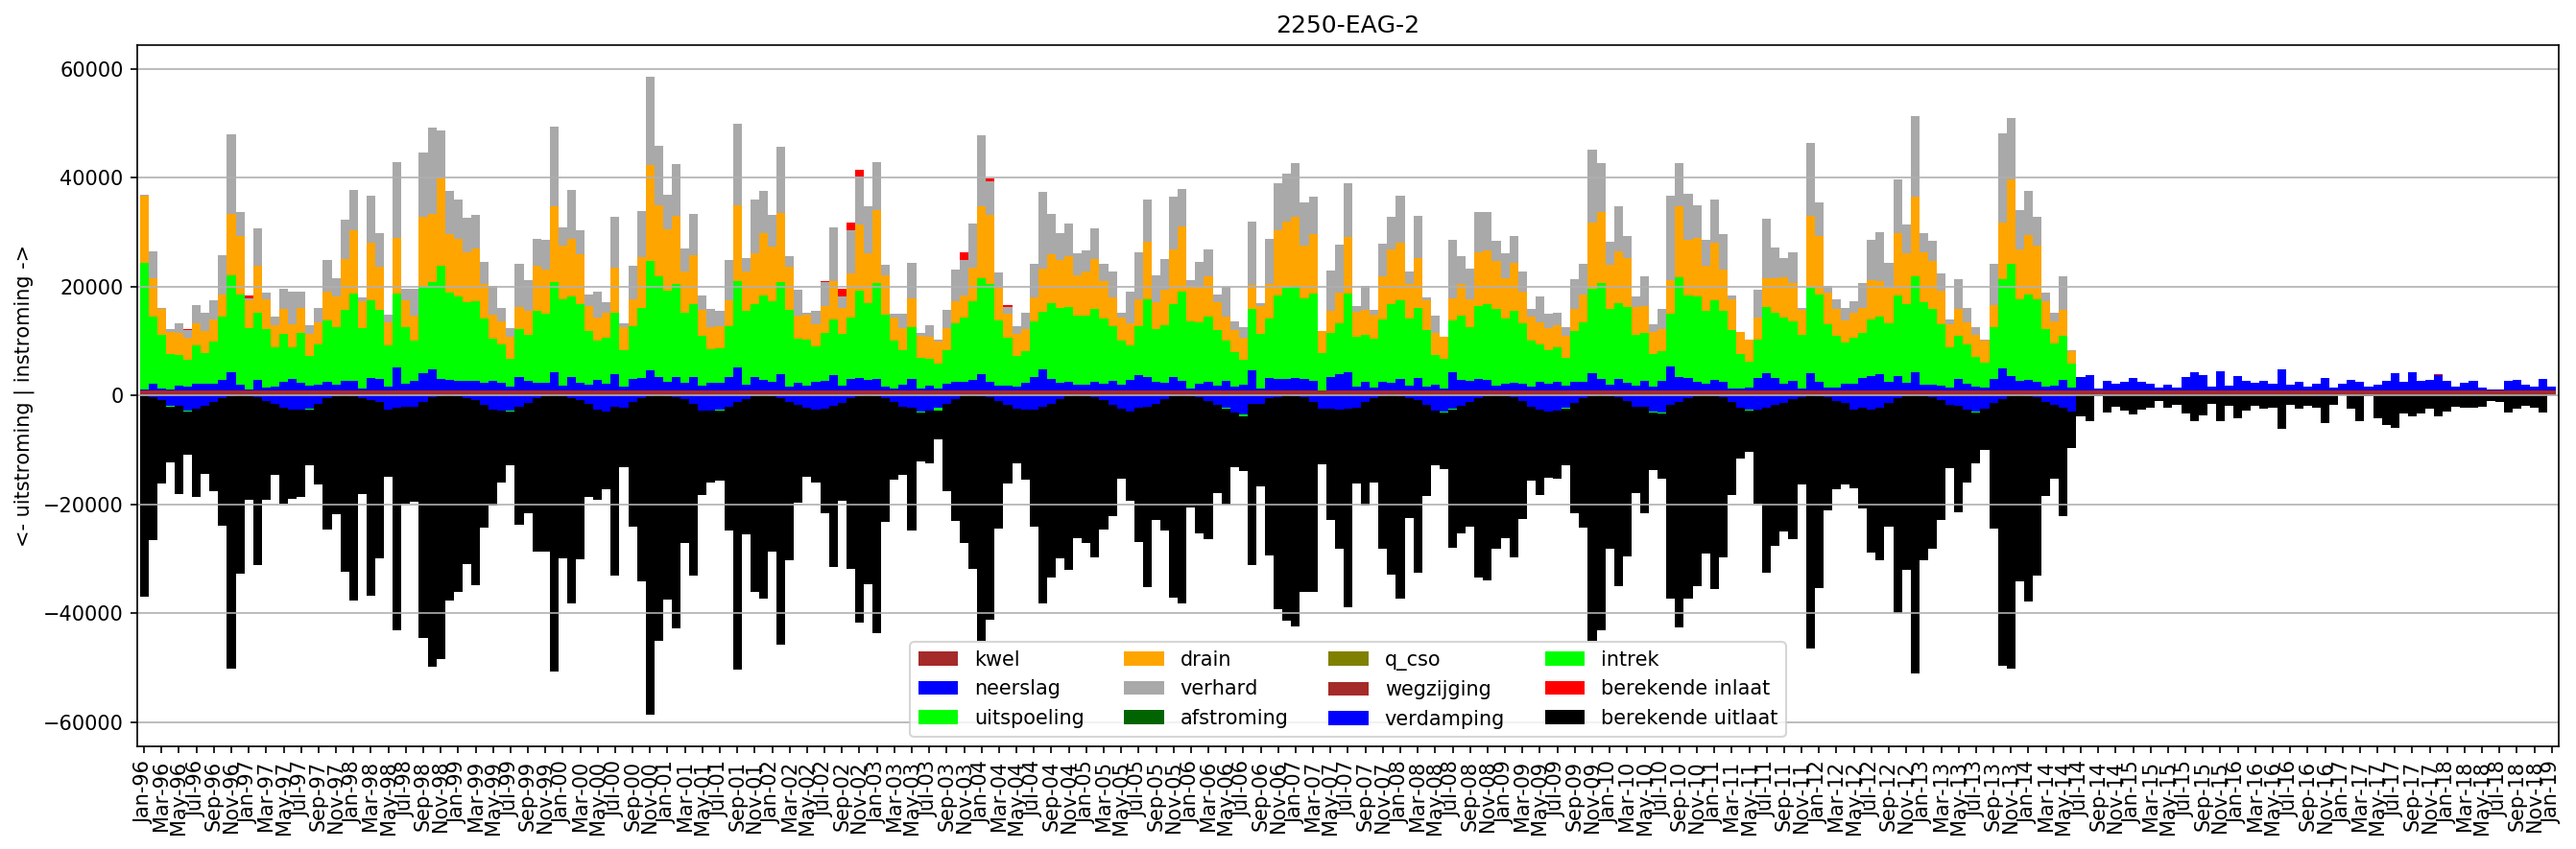

In [13]:
e.plot.aggregated()

## [Change an input parameter value after first simulation](#top)<a id="5"></a>

To modify the parameters of an EAG after it has been simulated:
1. Get the parameters used in the previous simulation
2. Modify the parameters you wish to change
3. Pass the new parameters to a new call to `e.simulate()`

Get the parameters:


In [14]:
new_params = e.get_parameter_df()
new_params.tail()

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
47,Water,85000000,hTargetMin,1,0.2
48,Water,85000000,hTargetMax,1,0.001
49,Water,85000000,hBottom,1,-5.33
50,Water,85000000,QInMax,1,0
51,Water,85000000,QOutMax,1,0


In [15]:
# edit hTargetMax
new_params.loc[48, "Waarde"] = 0.1
new_params.tail()

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
47,Water,85000000,hTargetMin,1,0.2
48,Water,85000000,hTargetMax,1,0.1
49,Water,85000000,hBottom,1,-5.33
50,Water,85000000,QInMax,1,0
51,Water,85000000,QOutMax,1,0


Simulate the Eag again:

In [16]:
e.simulate(new_params, tmin="1996", tmax="2019")

2019-07-23 14:15:30,774 | simulate - INFO : Simulating: 2250-EAG-2...
2019-07-23 14:15:30,782 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 85000282
2019-07-23 14:15:31,180 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000283
2019-07-23 14:15:31,535 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000284
2019-07-23 14:15:31,940 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000288
2019-07-23 14:15:32,355 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000289
2019-07-23 14:15:32,750 | simulate - INFO : Simulating the waterbalance for bucket: Water 85000000
2019-07-23 14:15:32,863 | simulate - WARNING : 'QInMax_1' is equal to 0. Assuming this means there is no limit to inflow.
2019-07-23 14:15:32,864 | simulate - WARNING : 'QOutMax_1' is equal to 0. Assuming this means there is no limit to outflow.
2019-07-23 14:15:37,370 | simulate - INFO : Simulation succesfully completed in 

Plot the results

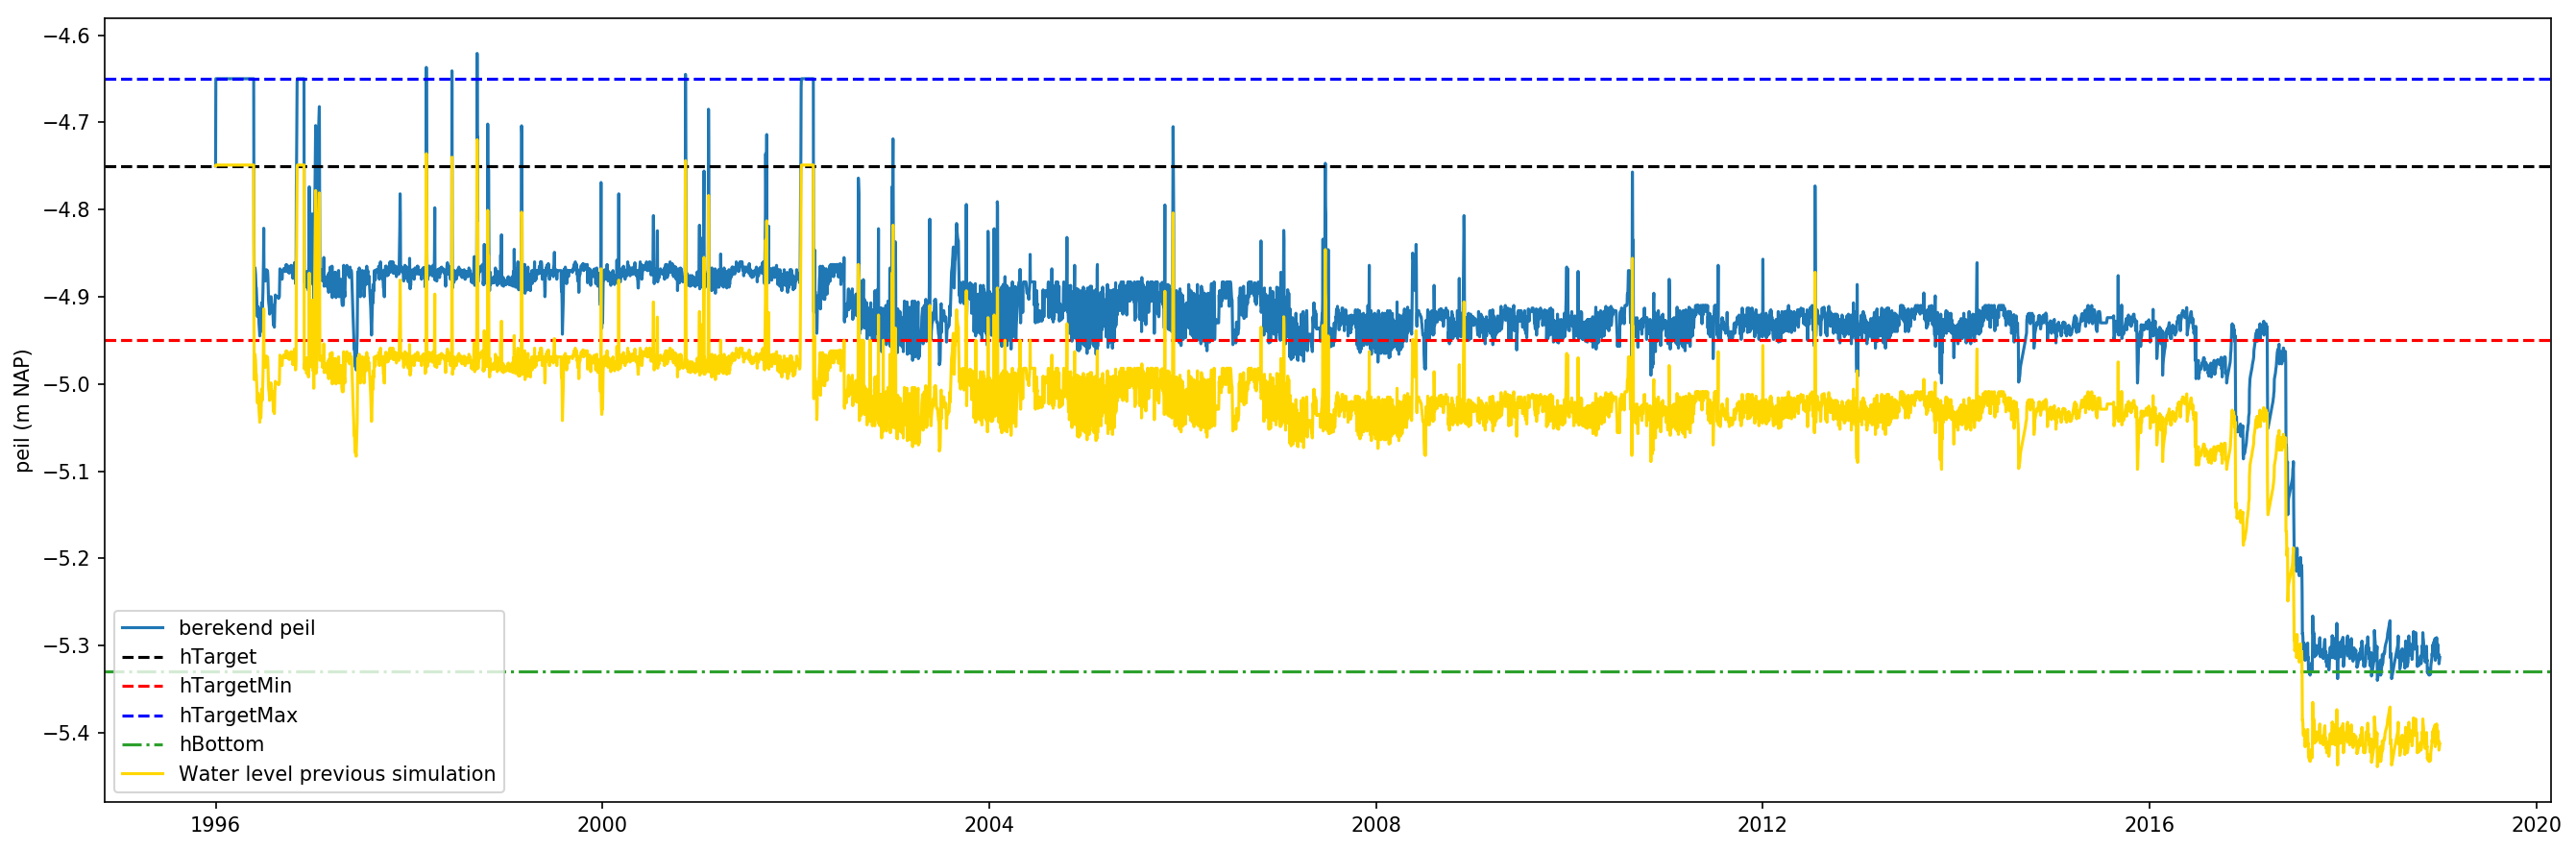

In [17]:
ax = e.plot.water_level()
ax.plot(old_water_level.index, old_water_level, color="gold", label="Water level previous simulation")
ax.legend(loc="best")

## [Add a bucket to an existing EAG](#top)<a id="6"></a>

Create a new Bucket.

In [18]:
new_bucket = wb.Verhard(10, e, None, area=10000.)

It is automatically added to the EAG:

In [27]:
e.get_modelstructure()

,Name,Area,BucketObj
ID,,,
85000282,Verhard,2915860.0,<85000282: Verhard bucket with area 2915860.0>
85000283,Onverhard,1964984.0,<85000283: Onverhard bucket with area 1964984.0>
85000284,Drain,1964984.0,<85000284: Drain bucket with area 1964984.0>
85000288,Onverhard,570826.0,<85000288: Onverhard bucket with area 570826.0>
85000289,Drain,570826.0,<85000289: Drain bucket with area 570826.0>
10,Verhard,10000.0,<10: Verhard bucket with area 10000.0>
85000000,Water,629220.0,<85000000: Water bucket with area 629220.0>


Get the parameters including the default values for the new bucket.

In [28]:
params_with_new_bucket = e.get_parameter_df()

View the parameters of the new bucket (adjust if you want):

In [29]:
params_with_new_bucket.loc[params_with_new_bucket.BakjeID == 10]

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
46,Verhard,10,hMax,1,0.2
47,Verhard,10,hMax,2,100
48,Verhard,10,hInit,1,50
49,Verhard,10,EFacMin,1,100
50,Verhard,10,EFacMax,1,100
51,Verhard,10,RFacIn,2,10
52,Verhard,10,RFacOut,2,10
53,Verhard,10,por,2,20


Note the presence of the new bucket in the simulation log:

In [24]:
e.simulate(params_with_new_bucket, tmin="1996", tmax="2019")

2019-07-23 14:19:34,488 | simulate - INFO : Simulating: 2250-EAG-2...
2019-07-23 14:19:34,491 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 85000282
2019-07-23 14:19:34,834 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000283
2019-07-23 14:19:35,160 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000284
2019-07-23 14:19:35,529 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000288
2019-07-23 14:19:35,870 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000289
2019-07-23 14:19:36,223 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 10
2019-07-23 14:19:36,259 | simulate - WARNING : Warning: {'Qkwel'} not in series. Assumed equal to 0!
2019-07-23 14:19:36,587 | simulate - INFO : Simulating the waterbalance for bucket: Water 85000000
2019-07-23 14:19:36,788 | simulate - WARNING : 'QInMax_1' is equal to 0. Assuming this means there is no limit to inflow.
2019-07-